# Workspace preparation

In [39]:
# Importing packages
import numpy as np  # for matrix and data manipulation
import pandas as pd  # for DataFrames
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for more plotitng
import statsmodels.api as sm  # for statistical modelling
import scikitplot as skplt  # for scikit-learn plotting

from sklearn.preprocessing import StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.svm import SVC  # SVM for classification
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

In [40]:
# Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [41]:
# Jupyter magic command to show plots inline immediately
%matplotlib inline

In [42]:
# Setting seed
seed = 43
np.random.seed(seed)

# Loading the data

In [43]:
# Loading the house price dataset
data_file_path = './'  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

# Training data
train_V2 = pd.read_csv(data_file_path + 'train_V2.csv')
score = pd.read_csv(data_file_path + 'score.csv')
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

#dictionary = pd.read_csv(data_file_path + 'dictionary.csv')
#print('Dictionary set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#print(train_V2.columns.tolist())
for col in score.columns.tolist():
    print(col)

income_am
profit_last_am
profit_am
damage_am
damage_inc
crd_lim_rec
credit_use_ic
gluten_ic
lactose_ic
insurance_ic
spa_ic
empl_ic
cab_requests
married_cd
bar_no
sport_ic
neighbor_income
age
marketing_permit
urban_ic
dining_ic
presidential
client_segment
sect_empl
prev_stay
prev_all_in_stay
divorce
fam_adult_size
children_no
tenure_mts
tenure_yrs
company_ic
claims_no
claims_am
nights_booked
gender
shop_am
shop_use
retired
gold_status
score1_pos
score1_neg
score2_pos
score2_neg
score3_pos
score3_neg
score4_pos
score4_neg
score5_pos
score5_neg


In [45]:
# Setting 'Id' columns as index
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

# Data preparation
## What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Calculate revenue

In [46]:
# The outcome to maximize is profit - damage
train_V2['revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']

All the variables seem to be numeric, except for the  `gender` : contains 'M' or 'V', replace by numeric value

In [47]:
#
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

# Initial exploration of data

In [48]:
train_V2[train_V2['outcome_damage_inc']==1].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount,revenue
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66,843.12
6,13293.0,28.0,14704.0,0.0,0.0,15000.0,0.0,1.0,1.0,1.0,1.0,0.0,8.0,True,18.0,0.0,33459.0,46.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,324.0,27.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,1.0,0.566906,0.846320,0.595743,0.901703,NaN,NaN,NaN,NaN,NaN,NaN,1676.75,1,888.09,788.66
9,229.0,810.0,1620.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,True,6.0,0.0,31718.0,29.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,145.0,12.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.196373,0.318601,NaN,NaN,NaN,NaN,1861.78,1,981.64,880.14
10,7177.0,2887.0,3770.0,0.0,0.0,15000.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,True,11.0,0.0,34575.0,53.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,167.0,14.0,0.0,0.0,0.0,19.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.222590,0.130548,NaN,NaN,0.276508,0.882461,NaN,NaN,1761.14,1,483.05,1278.09
11,3240.0,1212.0,2750.0,2762.0,6.0,12000.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,True,9.0,1.0,31135.0,53.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,477.0,40.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.390233,0.526528,NaN,NaN,NaN,NaN,0.044849,0.649934,NaN,NaN,2109.04,1,1046.70,1062.34


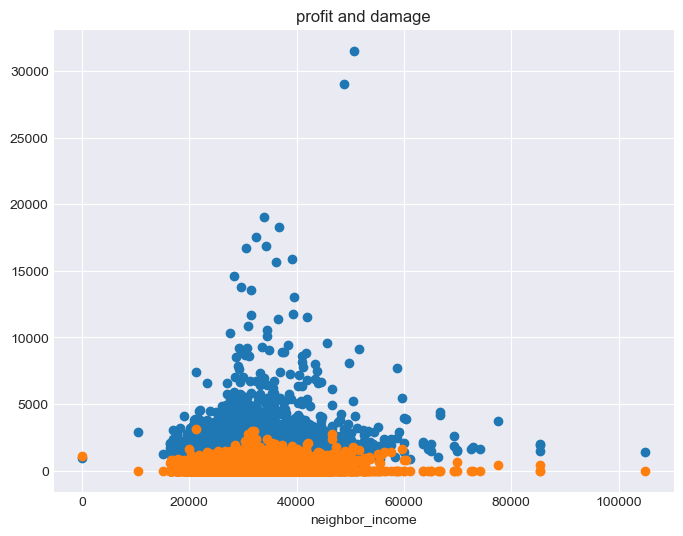

In [49]:
# Plotting
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

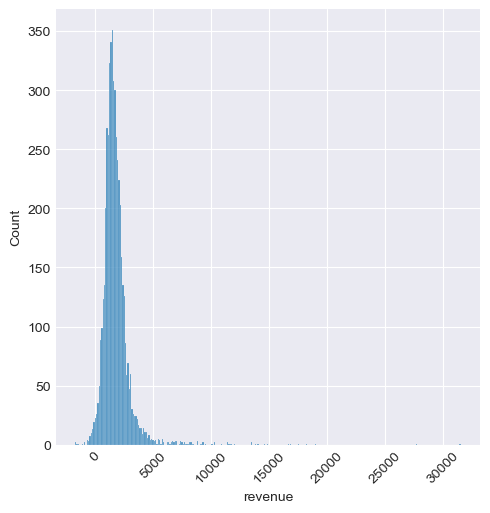

In [50]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['revenue']);  # With seaborn for a change
plt.xticks(rotation=45); # Rotating x labels

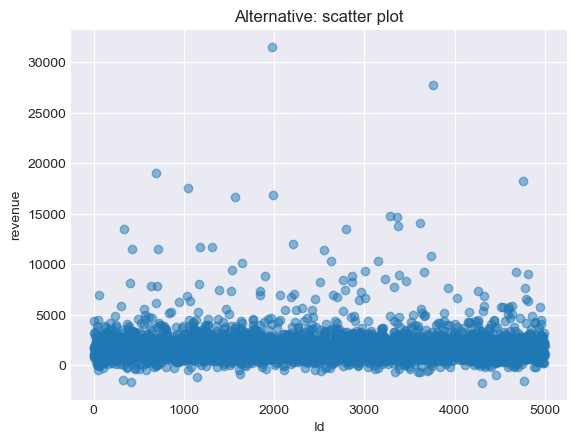

In [51]:
# But I guess a scatter plot would've done well also

plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['revenue'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

# The data seems to be evenly distributed, no shuffling is needed

# Handle missing data
1. Getting missing values descending per feature
2. Drop features with more than 15% missing values
3. Find instances with missing observations (% of missing for a lot of features is equal > it appears these values for these featues are missing for the same instances)

In [52]:
import scipy.stats as stats

train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])

In [53]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount,revenue,score5_neg_uniform
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00,1791.66,NaN
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66,843.12,0.808991
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00,1001.40,0.137461
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00,1785.59,NaN
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00,3140.74,NaN


<Axes: >

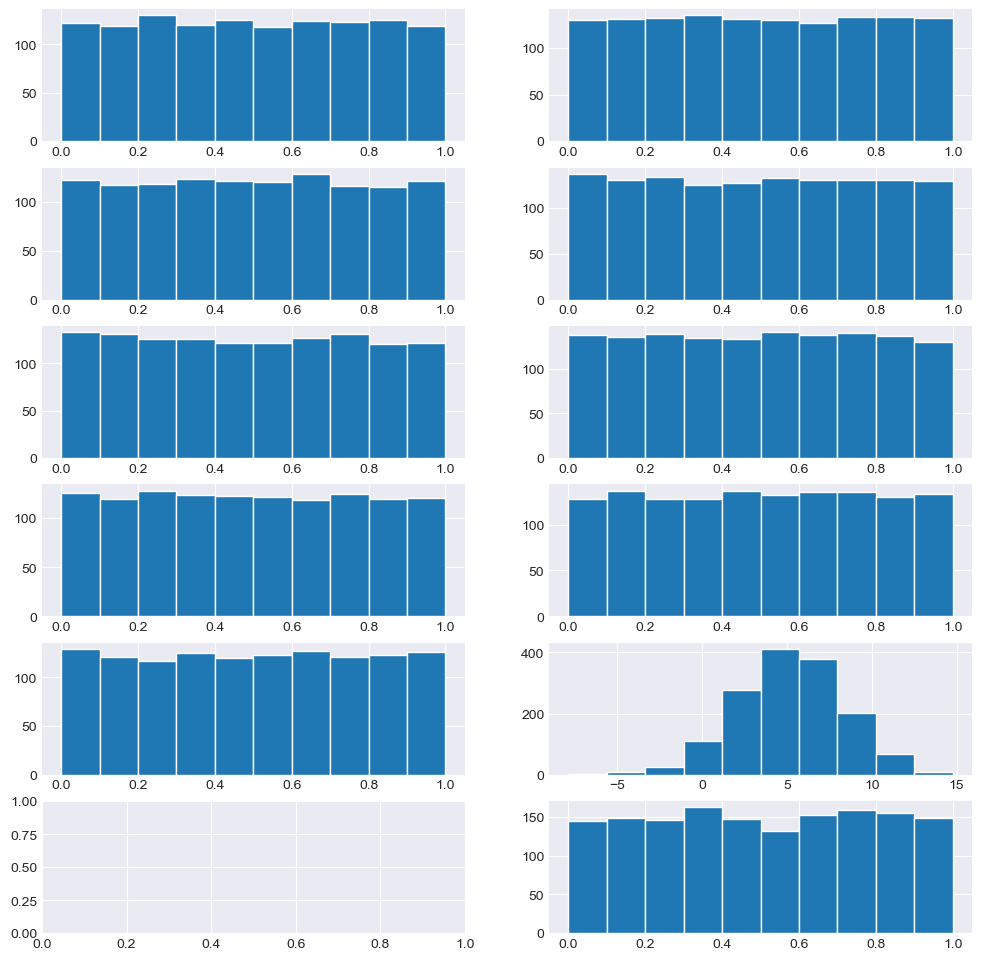

In [54]:
score_pos_features = ['score1_pos','score2_pos','score3_pos','score4_pos','score5_pos']
score_neg_features = ['score1_neg','score2_neg','score3_neg','score4_neg','score5_neg']

fig, axs = plt.subplots(6,2, figsize=(12,12))
i=0
for i in range(1,6):
    train_V2[score_pos_features[i-1]].hist(ax=axs[i-1][0])
    train_V2[score_neg_features[i-1]].hist(ax=axs[i-1][1])

train_V2["score5_neg_uniform"].hist(ax=axs[5][1])


In [55]:
train_V2["score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg_uniform"]].mean(axis=1)

In [56]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount,revenue,score5_neg_uniform,score_pos,score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00,1791.66,NaN,0.652958,0.532814
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66,843.12,0.808991,NaN,0.808991
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00,1001.40,0.137461,0.167165,0.118495
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00,1785.59,NaN,NaN,0.889793
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00,3140.74,NaN,0.410495,0.654370


In [64]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
total_missings.head(20)  # Show top 20 most missing features

# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
pct_missings.head(20)  # Show top 20 most missing features

score2_pos            0.7582
score4_pos            0.7554
score1_pos            0.7550
score5_pos            0.7536
score3_pos            0.7478
score2_neg            0.7392
score1_neg            0.7372
score4_neg            0.7352
score3_neg            0.7266
score5_neg_uniform    0.7014
score5_neg            0.7014
score_pos             0.3194
score_neg             0.2332
tenure_yrs            0.0784
tenure_mts            0.0784
neighbor_income       0.0478
cab_requests          0.0176
shop_use              0.0176
dining_ic             0.0176
presidential          0.0176
dtype: float64

## Impute missing data
## ***

Investigate the number of unique values per attribute and the unique values themselves. The goal is to investigate which features should be treated as categorical. A first step is identifying which features unique values are not numeric. In the second step we will investigate which of the numerice attributes could potentially be a boolean.

In [67]:
train_nunique = train_V2.nunique()

train_unique = train_nunique.to_frame('unique_count')

train_unique['unique_values'] = train_V2.apply(lambda col: col.unique())

# List datatypes of the unique values

train_unique['datatype'] = train_V2.apply(lambda col: col.dtypes)

# merge previous missings percentages dataseries with the uinque values dataframe

pct_missings = pct_missings.to_frame('pct_missing')

train_unique_missings = train_unique.merge(pct_missings, left_index=True, right_index=True)

# Sort descending by unique values

train_unique_missings.sort_values(by='unique_count', ascending = False, inplace = True)

# Select columns that have the 'object' datatype and investigate underlying datatype

train_unique_dtypeobject = train_unique_missings[train_unique_missings['datatype']=='object']

train_unique_dtypeobject['categorical'] = 1

for i, row in train_unique_dtypeobject.iterrows():
    valuelist = row['unique_values']
    for value in valuelist:
        if type(value) == str:
            continue
        elif np.isnan(value):
            continue
        else:
            train_unique_dtypeobject.loc[i, 'categorical'] = 0
            
train_unique_no_cat = train_unique_missings.drop(train_unique_dtypeobject[train_unique_dtypeobject['categorical']== 1].index)

In [68]:
print('Number of object dtype columns that only have str values and are likely categorical:' + str(train_unique_dtypeobject[train_unique_dtypeobject['categorical']== 1].count()))
train_unique_dtypeobject[train_unique_dtypeobject['categorical']== 1]

Number of object dtype columns that only have str values and are likely categorical:unique_count     0
unique_values    0
datatype         0
pct_missing      0
categorical      0
dtype: int64


,unique_count,unique_values,datatype,pct_missing,categorical


In [69]:
print('Number of object dtype columns that have other than str values and need further investigation to determine if they are categorical:' + str(train_unique_dtypeobject[train_unique_dtypeobject['categorical']== 0].count()))
train_unique_dtypeobject[train_unique_dtypeobject['categorical'] == 0]

Number of object dtype columns that have other than str values and need further investigation to determine if they are categorical:unique_count     0
unique_values    0
datatype         0
pct_missing      0
categorical      0
dtype: int64


,unique_count,unique_values,datatype,pct_missing,categorical


In [70]:
# Select columns that are booleans

train_unique_dtypebool = train_unique_no_cat[train_unique_missings['datatype']=='bool']

train_unique_no_bool = train_unique_no_cat.drop(train_unique_dtypebool.index)

print('Number of bool dtype and thus are categorical:' + str(train_unique_dtypebool.count()))
train_unique_dtypebool

Number of bool dtype and thus are categorical:unique_count     1
unique_values    1
datatype         1
pct_missing      1
dtype: int64


,unique_count,unique_values,datatype,pct_missing
married_cd,2,"[True, False]",bool,0.0


In [71]:
# select boolean potentials

train_unique_potbool = train_unique_no_bool[train_unique_no_cat['unique_count']==2]

print('Potential boolean 1/0 columns:' + str(train_unique_potbool['unique_count'].count() + train_unique_dtypebool['unique_values'].count()))


Potential boolean 1/0 columns:21


C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\821154156.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_unique_potbool = train_unique_no_bool[train_unique_no_cat['unique_count']==2]


In [72]:
# identify boolean potentials with only 1 / O numeric values

train_unique_potbool['bool'] = 1

for i, row in train_unique_potbool.iterrows():
    valuelist = row['unique_values']
    for value in valuelist:
        if value == 0.0:
            continue
        elif value == 1.0:
            continue
        elif np.isnan(value):
            continue
        else:
            train_unique_potbool.loc[i, 'bool'] = 0
            
train_unique_no_potbool = train_unique_no_bool.drop(train_unique_potbool[train_unique_potbool['bool']== 1].index)

C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\3371859100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_unique_potbool['bool'] = 1


In [73]:
print('Number of columns that only have 1 / 0 values as its unique values:' + str(train_unique_potbool[train_unique_potbool['bool']== 1].count()))
train_unique_potbool[train_unique_potbool['bool']== 1]

Number of columns that only have 1 / 0 values as its unique values:unique_count     20
unique_values    20
datatype         20
pct_missing      20
bool             20
dtype: int64


,unique_count,unique_values,datatype,pct_missing,bool
lactose_ic,2,"[0.0, 1.0, nan]",float64,0.0106,1
urban_ic,2,"[1.0, 0.0, nan]",float64,0.0106,1
insurance_ic,2,"[0.0, 1.0, nan]",float64,0.0106,1
spa_ic,2,"[1.0, 0.0, nan]",float64,0.0060,1
empl_ic,2,"[0.0, 1.0, nan]",float64,0.0002,1
outcome_damage_inc,2,"[0, 1]",int64,0.0000,1
sport_ic,2,"[1.0, 0.0, nan]",float64,0.0106,1
credit_use_ic,2,"[0.0, 1.0, nan]",float64,0.0106,1
marketing_permit,2,"[0.0, 1.0, nan]",float64,0.0106,1
presidential,2,"[0.0, nan, 1.0]",float64,0.0176,1


In [74]:
print('Number of columns that where identified as potentially being boolean but not only having 1 / 0 values as its unique values, these need to be assessed whether these are numeric or categorical:' + str(train_unique_potbool[train_unique_potbool['bool']== 0].count()))
train_unique_potbool[train_unique_potbool['bool']== 0]

Number of columns that where identified as potentially being boolean but not only having 1 / 0 values as its unique values, these need to be assessed whether these are numeric or categorical:unique_count     0
unique_values    0
datatype         0
pct_missing      0
bool             0
dtype: int64


,unique_count,unique_values,datatype,pct_missing,bool


Based on the above results and assessment of the feature names in combination with the unique values of the features we assume that all columns with datatypes 'boolean' and 'object', and all columns with only two unique values are categorical columns. These columns can all be expressed as boolean results, although nan are present that also need to be addressed. This leaves us to also evaluate whether there are still non boolean categorical features present in the remaining features. We assume it is more likely that categories are encoded with whole numbers and that the number of categories used will only exceptionally exceed more than two digits. So to aid in identifying potential categorical features we will filter on whole number and sort the resulting list ascending.

In [75]:
# Find non whole values by comparing unique values to their version cast to integer

train_unique_no_potbool['whole'] = 1

for i, row in train_unique_no_potbool.iterrows():
    valuelist = row['unique_values']
    for value in valuelist:
        if value == value.astype(int):
            continue
        elif np.isnan(value):
            continue
        else:
            train_unique_no_potbool.loc[i, 'whole'] = 0

train_unique_whole = train_unique_no_potbool[train_unique_no_potbool['whole']==1]

train_unique_whole.sort_values(by='unique_count', ascending = True, inplace = True)

train_unique_whole

C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value encountered in cast
  if value == value.astype(int):
C:\Users\RekenPC\AppData\Local\Temp\ipykernel_1976\523507482.py:8: RuntimeWarning: invalid value enc

,unique_count,unique_values,datatype,pct_missing,whole
fam_adult_size,4,"[3.0, 1.0, 2.0, nan, 4.0]",float64,0.0106,1
sect_empl,6,"[1.0, 0.0, 4.0, 6.0, nan, 2.0, 3.0]",float64,0.0106,1
client_segment,6,"[1.0, 2.0, 3.0, 0.0, 4.0, 5.0, nan]",float64,0.0106,1
children_no,7,"[2.0, 0.0, 1.0, 3.0, nan, 4.0, 5.0, 6.0]",float64,0.0106,1
claims_no,10,"[0.0, 2.0, 1.0, 3.0, nan, 7.0, 6.0, 4.0, 5.0, ...",float64,0.0106,1
damage_inc,11,"[6.0, 0.0, 2.0, 4.0, 3.0, 1.0, 5.0, nan, 7.0, ...",float64,0.0106,1
cab_requests,17,"[3.0, 7.0, 1.0, 6.0, 4.0, 8.0, nan, 11.0, 10.0...",float64,0.0176,1
crd_lim_rec,41,"[15000.0, 750.0, 0.0, 14000.0, 12000.0, 3500.0...",float64,0.0106,1
bar_no,47,"[2.0, 3.0, 4.0, 8.0, 6.0, 18.0, 9.0, 11.0, 5.0...",float64,0.0106,1
tenure_yrs,58,"[40.0, 2.0, 8.0, nan, 30.0, 29.0, 27.0, 0.0, 1...",float64,0.0784,1


Sect_empl, client_segment can also be identified als likely categorical values.

In [76]:
train_unique_cat_nonbool = train_unique_whole.loc[['sect_empl','client_segment'],:]

In [78]:
train_unique_not_whole = train_unique_no_potbool.drop(train_unique_whole.index)

train_unique_whole = train_unique_whole.drop(train_unique_cat_nonbool.index)

train_unique_not_whole.sort_values(by='unique_count', ascending = True, inplace = True)

train_unique_not_whole

,unique_count,unique_values,datatype,pct_missing,whole
shop_am,723,"[0.0, 1454.2106266736826, 3667.808726446357, 1...",float64,0.0106,0
score2_pos,1209,"[nan, 0.2323748565109472, 0.5957434445890715, ...",float64,0.7582,0
score4_pos,1223,"[0.8381471071753719, nan, 0.4904860478691031, ...",float64,0.7554,0
score1_pos,1225,"[0.4677681895937277, nan, 0.5669064700512313, ...",float64,0.7550,0
score5_pos,1232,"[nan, 0.1019548979044747, 0.5834235505559962, ...",float64,0.7536,0
score3_pos,1261,"[nan, 0.3305032292193999, 0.4210636166946807, ...",float64,0.7478,0
outcome_damage_amount,1268,"[0.0, 829.66, 888.09, 981.64, 483.05, 1046.7, ...",float64,0.0000,0
score2_neg,1304,"[nan, 0.099528773617558, 0.9017025974768614, 0...",float64,0.7392,0
score1_neg,1314,"[0.9833398100939352, nan, 0.8463201114717805, ...",float64,0.7372,0
score4_neg,1324,"[0.0822880001580627, nan, 0.5424453606796794, ...",float64,0.7352,0


In [82]:
train_unique_numeric = pd.concat([train_unique_not_whole, train_unique_whole])

In [83]:
train_unique_numeric

,unique_count,unique_values,datatype,pct_missing,whole
shop_am,723,"[0.0, 1454.2106266736826, 3667.808726446357, 1...",float64,0.0106,0
score2_pos,1209,"[nan, 0.2323748565109472, 0.5957434445890715, ...",float64,0.7582,0
score4_pos,1223,"[0.8381471071753719, nan, 0.4904860478691031, ...",float64,0.7554,0
score1_pos,1225,"[0.4677681895937277, nan, 0.5669064700512313, ...",float64,0.7550,0
score5_pos,1232,"[nan, 0.1019548979044747, 0.5834235505559962, ...",float64,0.7536,0
score3_pos,1261,"[nan, 0.3305032292193999, 0.4210636166946807, ...",float64,0.7478,0
outcome_damage_amount,1268,"[0.0, 829.66, 888.09, 981.64, 483.05, 1046.7, ...",float64,0.0000,0
score2_neg,1304,"[nan, 0.099528773617558, 0.9017025974768614, 0...",float64,0.7392,0
score1_neg,1314,"[0.9833398100939352, nan, 0.8463201114717805, ...",float64,0.7372,0
score4_neg,1324,"[0.0822880001580627, nan, 0.5424453606796794, ...",float64,0.7352,0


Below code and also part of above code should be adapted to allow the code to be more generically applicable as the below concat only works correctly with the original dataset.

In [85]:
train_unique_categorical = pd.concat([train_unique_cat_nonbool, train_unique_potbool, train_unique_dtypebool])

In [86]:
train_unique_categorical

,unique_count,unique_values,datatype,pct_missing,whole,bool
sect_empl,6,"[1.0, 0.0, 4.0, 6.0, nan, 2.0, 3.0]",float64,0.0106,1.0,NaN
client_segment,6,"[1.0, 2.0, 3.0, 0.0, 4.0, 5.0, nan]",float64,0.0106,1.0,NaN
lactose_ic,2,"[0.0, 1.0, nan]",float64,0.0106,NaN,1.0
urban_ic,2,"[1.0, 0.0, nan]",float64,0.0106,NaN,1.0
insurance_ic,2,"[0.0, 1.0, nan]",float64,0.0106,NaN,1.0
spa_ic,2,"[1.0, 0.0, nan]",float64,0.0060,NaN,1.0
empl_ic,2,"[0.0, 1.0, nan]",float64,0.0002,NaN,1.0
outcome_damage_inc,2,"[0, 1]",int64,0.0000,NaN,1.0
sport_ic,2,"[1.0, 0.0, nan]",float64,0.0106,NaN,1.0
credit_use_ic,2,"[0.0, 1.0, nan]",float64,0.0106,NaN,1.0


In [97]:
score_col = ["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos", "score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg_uniform"]
no_score_col = train_unique_numeric.drop(score_col)

In [98]:
no_score_col

,unique_count,unique_values,datatype,pct_missing,whole
shop_am,723,"[0.0, 1454.2106266736826, 3667.808726446357, 1...",float64,0.0106,0
outcome_damage_amount,1268,"[0.0, 829.66, 888.09, 981.64, 483.05, 1046.7, ...",float64,0.0000,0
profit_last_am,1452,"[0.0, 16.0, 23.0, 1028.0, 289.0, 28.0, 810.0, ...",float64,0.0106,0
score5_neg,1493,"[nan, 7.955259224614119, 1.74302014705614, 6.8...",float64,0.7014,0
score_pos,3403,"[0.6529576483845498, nan, 0.16716487720771095,...",float64,0.3194,0
score_neg,3834,"[0.532813905125999, 0.8089910261203815, 0.1184...",float64,0.2332,0
outcome_profit,4955,"[1791.66, 1672.78, 1001.4, 1785.59, 3140.74, 4...",float64,0.0000,0
revenue,4963,"[1791.66, 843.12, 1001.4, 1785.59, 3140.74, 43...",float64,0.0000,0
fam_adult_size,4,"[3.0, 1.0, 2.0, nan, 4.0]",float64,0.0106,1
children_no,7,"[2.0, 0.0, 1.0, 3.0, nan, 4.0, 5.0, 6.0]",float64,0.0106,1


In [105]:
impute_quant_ind = SimpleImputer(strategy='mean', add_indicator=True)

test = impute_quant_ind.fit_transform(X=train_V2[score_col])

In [107]:
test

array([[0.46776819, 0.49855219, 0.49428009, ..., 0.4985876 , 0.082288  ,
        0.50219844],
       [0.49973556, 0.49855219, 0.49428009, ..., 0.4985876 , 0.50139618,
        0.80899103],
       [0.49973556, 0.23237486, 0.49428009, ..., 0.4985876 , 0.50139618,
        0.13746129],
       ...,
       [0.49973556, 0.41781713, 0.49428009, ..., 0.4985876 , 0.33113903,
        0.50219844],
       [0.49973556, 0.49855219, 0.49428009, ..., 0.4985876 , 0.38881538,
        0.50219844],
       [0.49973556, 0.49855219, 0.49428009, ..., 0.4985876 , 0.50139618,
        0.29112578]])

In [100]:
train_V2[train_unique_numeric.index].head()

,shop_am,score2_pos,score4_pos,score1_pos,score5_pos,score3_pos,outcome_damage_amount,score2_neg,score1_neg,score4_neg,score3_neg,profit_last_am,score5_neg,score5_neg_uniform,score_pos,score_neg,outcome_profit,revenue,fam_adult_size,children_no,claims_no,damage_inc,cab_requests,crd_lim_rec,bar_no,tenure_yrs,age,claims_am,nights_booked,tenure_mts,damage_am,income_am,profit_am,neighbor_income
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.498552,0.838147,0.467768,0.500959,0.494280,0.00,0.496734,0.983340,0.082288,0.498588,0.0,5.192953,0.502198,0.652958,0.532814,1791.66,1791.66,3.0,2.0,0.0,6.0,3.0,15000.0,2.0,40.000000,37.0,0.0,209.0,476.000000,888.0,227.0,3201.0,28936.0
1,0.000000,0.498552,0.496206,0.499736,0.500959,0.494280,829.66,0.496734,0.500366,0.501396,0.498588,16.0,7.955259,0.808991,0.497496,0.808991,1672.78,843.12,1.0,0.0,0.0,0.0,7.0,750.0,3.0,2.000000,18.0,0.0,4.0,27.000000,0.0,268.0,1682.0,16674.0
2,0.000000,0.232375,0.496206,0.499736,0.101955,0.494280,0.00,0.099529,0.500366,0.501396,0.498588,23.0,1.743020,0.137461,0.167165,0.118495,1001.40,1001.40,1.0,0.0,0.0,0.0,1.0,750.0,4.0,8.000000,21.0,0.0,6.0,95.000000,0.0,283.0,1673.0,32552.0
3,0.000000,0.498552,0.496206,0.499736,0.500959,0.494280,0.00,0.496734,0.500366,0.501396,0.889793,0.0,5.192953,0.502198,0.497496,0.889793,1785.59,1785.59,3.0,2.0,0.0,0.0,6.0,0.0,8.0,22.780165,37.0,0.0,4.0,273.111545,0.0,227.0,1685.0,32252.0
4,1454.210627,0.498552,0.490486,0.499736,0.500959,0.330503,0.00,0.496734,0.500366,0.542445,0.766294,1028.0,5.192953,0.502198,0.410495,0.654370,3140.74,3140.74,2.0,0.0,0.0,2.0,4.0,14000.0,2.0,30.000000,26.0,0.0,3.0,354.000000,785.0,4091.0,3425.0,29605.0


In [92]:
impute_quant = SimpleImputer(strategy='mean').set_output(transform='pandas')

train_V2[train_unique_numeric.index] = impute_quant.fit_transform(X=train_V2[train_unique_numeric.index])

In [93]:
train_V2[train_unique_numeric.index].head()

,shop_am,score2_pos,score4_pos,score1_pos,score5_pos,score3_pos,outcome_damage_amount,score2_neg,score1_neg,score4_neg,score3_neg,profit_last_am,score5_neg,score5_neg_uniform,score_pos,score_neg,outcome_profit,revenue,fam_adult_size,children_no,claims_no,damage_inc,cab_requests,crd_lim_rec,bar_no,tenure_yrs,age,claims_am,nights_booked,tenure_mts,damage_am,income_am,profit_am,neighbor_income
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.498552,0.838147,0.467768,0.500959,0.494280,0.00,0.496734,0.983340,0.082288,0.498588,0.0,5.192953,0.502198,0.652958,0.532814,1791.66,1791.66,3.0,2.0,0.0,6.0,3.0,15000.0,2.0,40.000000,37.0,0.0,209.0,476.000000,888.0,227.0,3201.0,28936.0
1,0.000000,0.498552,0.496206,0.499736,0.500959,0.494280,829.66,0.496734,0.500366,0.501396,0.498588,16.0,7.955259,0.808991,0.497496,0.808991,1672.78,843.12,1.0,0.0,0.0,0.0,7.0,750.0,3.0,2.000000,18.0,0.0,4.0,27.000000,0.0,268.0,1682.0,16674.0
2,0.000000,0.232375,0.496206,0.499736,0.101955,0.494280,0.00,0.099529,0.500366,0.501396,0.498588,23.0,1.743020,0.137461,0.167165,0.118495,1001.40,1001.40,1.0,0.0,0.0,0.0,1.0,750.0,4.0,8.000000,21.0,0.0,6.0,95.000000,0.0,283.0,1673.0,32552.0
3,0.000000,0.498552,0.496206,0.499736,0.500959,0.494280,0.00,0.496734,0.500366,0.501396,0.889793,0.0,5.192953,0.502198,0.497496,0.889793,1785.59,1785.59,3.0,2.0,0.0,0.0,6.0,0.0,8.0,22.780165,37.0,0.0,4.0,273.111545,0.0,227.0,1685.0,32252.0
4,1454.210627,0.498552,0.490486,0.499736,0.500959,0.330503,0.00,0.496734,0.500366,0.542445,0.766294,1028.0,5.192953,0.502198,0.410495,0.654370,3140.74,3140.74,2.0,0.0,0.0,2.0,4.0,14000.0,2.0,30.000000,26.0,0.0,3.0,354.000000,785.0,4091.0,3425.0,29605.0


In [94]:
train_V2[train_unique_categorical.index].head()

,sect_empl,client_segment,lactose_ic,urban_ic,insurance_ic,spa_ic,empl_ic,outcome_damage_inc,sport_ic,credit_use_ic,marketing_permit,presidential,dining_ic,company_ic,prev_stay,prev_all_in_stay,divorce,gold_status,retired,shop_use,gender,gluten_ic,married_cd
Id,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False


In [95]:
impute_cat = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')

train_V2[train_unique_categorical.index] = impute_quant.fit_transform(X=train_V2[train_unique_categorical.index])

In [96]:
train_V2[train_unique_categorical.index].head()

,sect_empl,client_segment,lactose_ic,urban_ic,insurance_ic,spa_ic,empl_ic,outcome_damage_inc,sport_ic,credit_use_ic,marketing_permit,presidential,dining_ic,company_ic,prev_stay,prev_all_in_stay,divorce,gold_status,retired,shop_use,gender,gluten_ic,married_cd
Id,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Visualizing / Exploring data

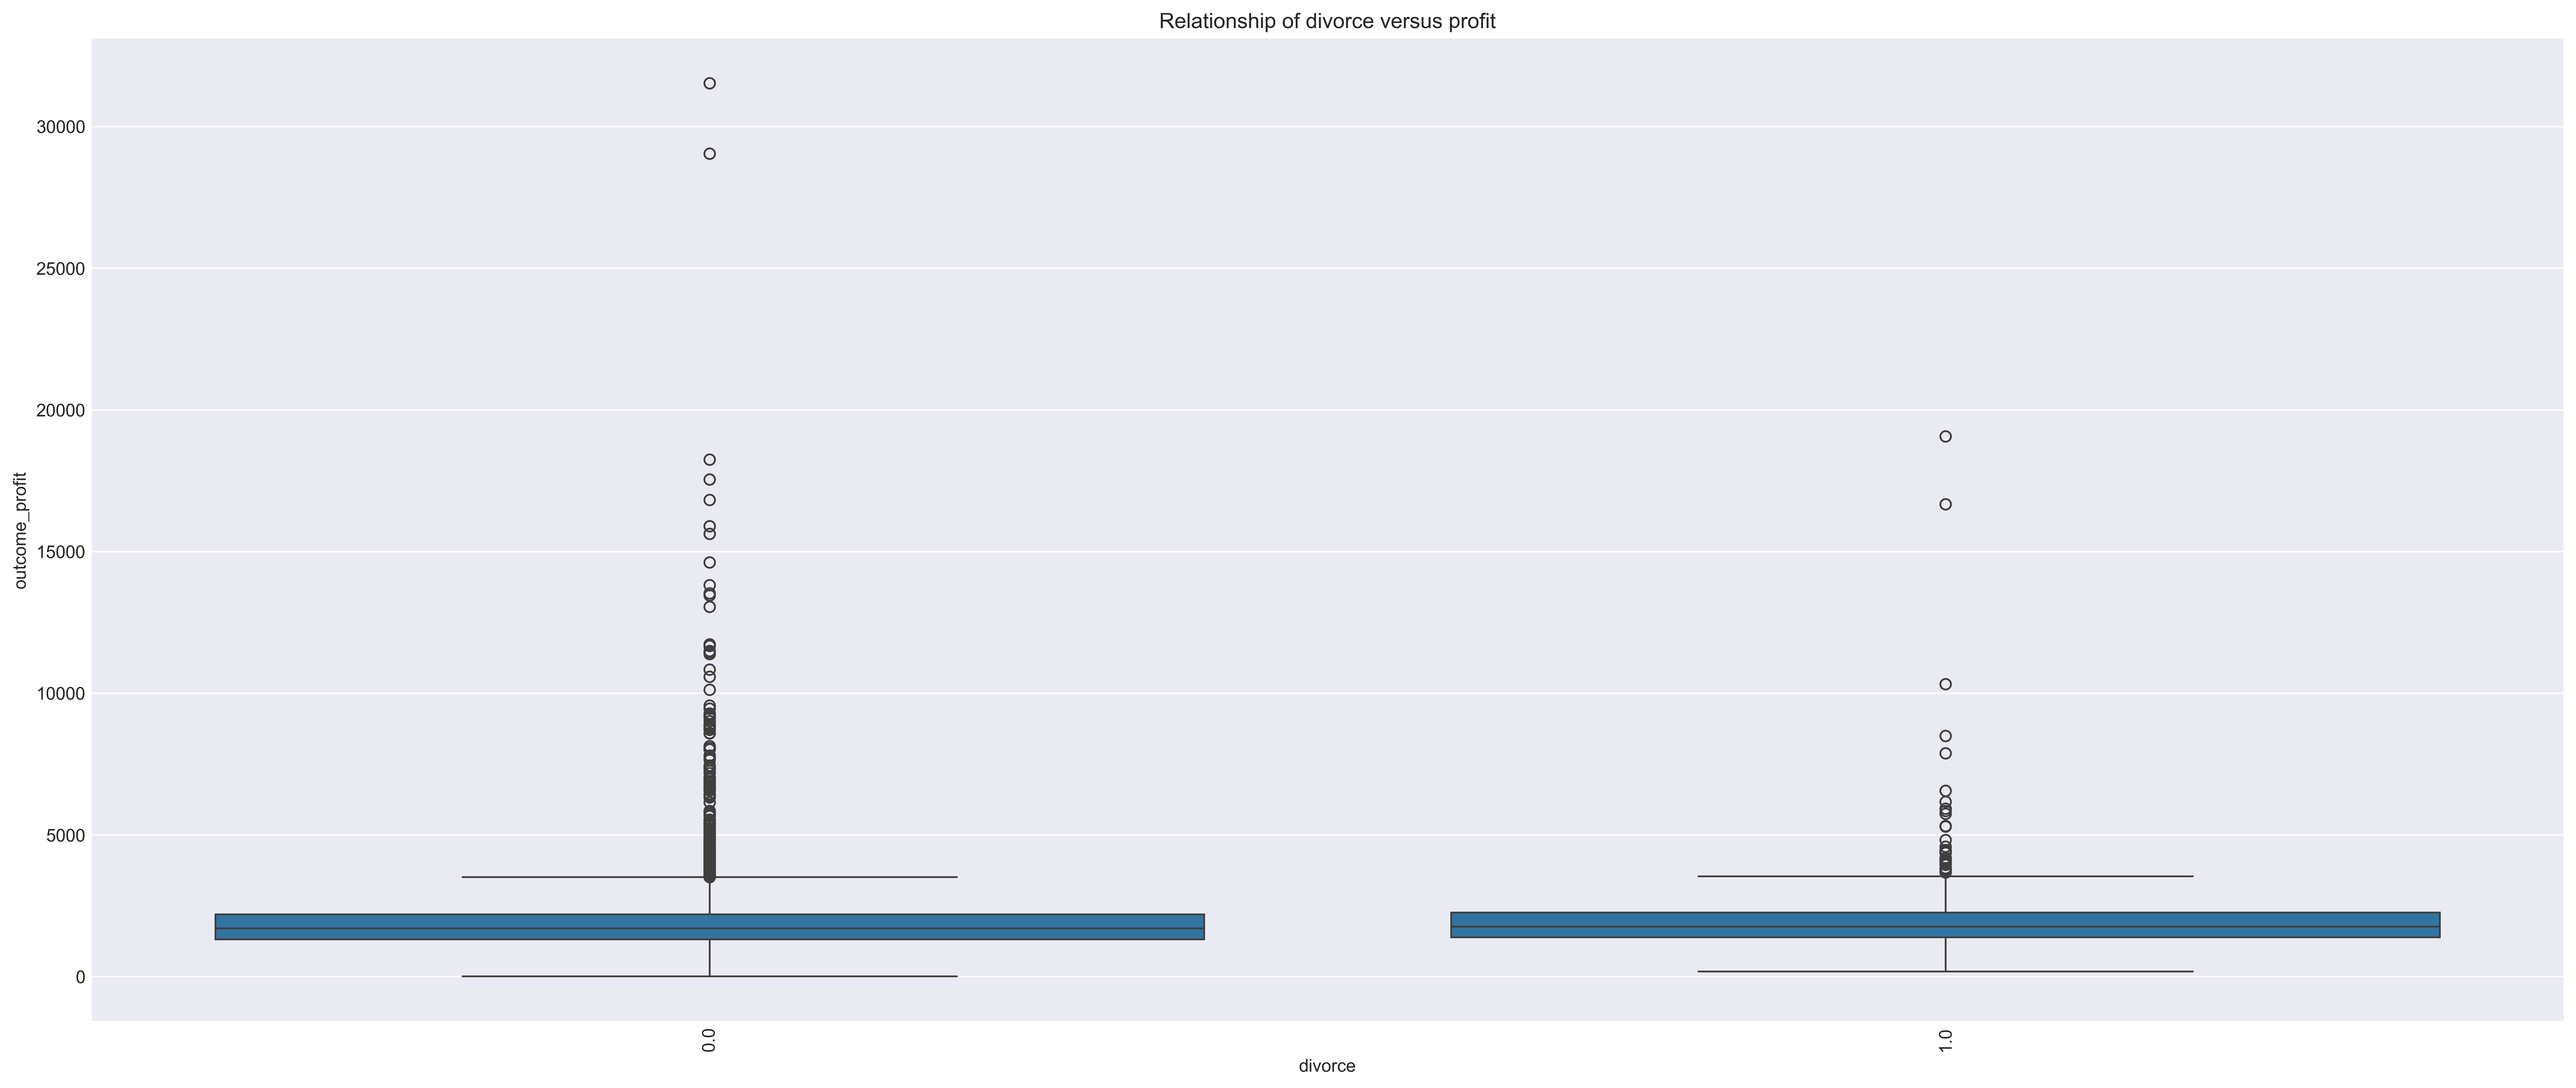

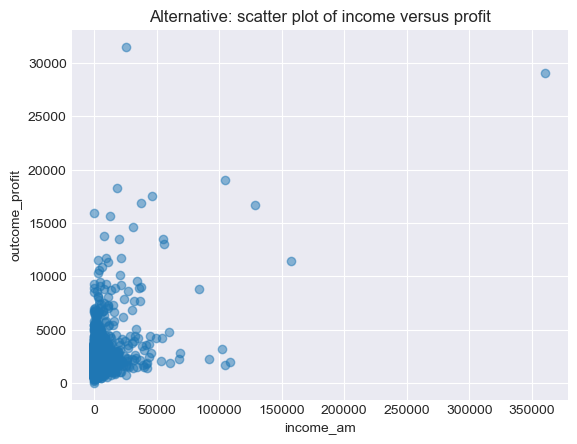

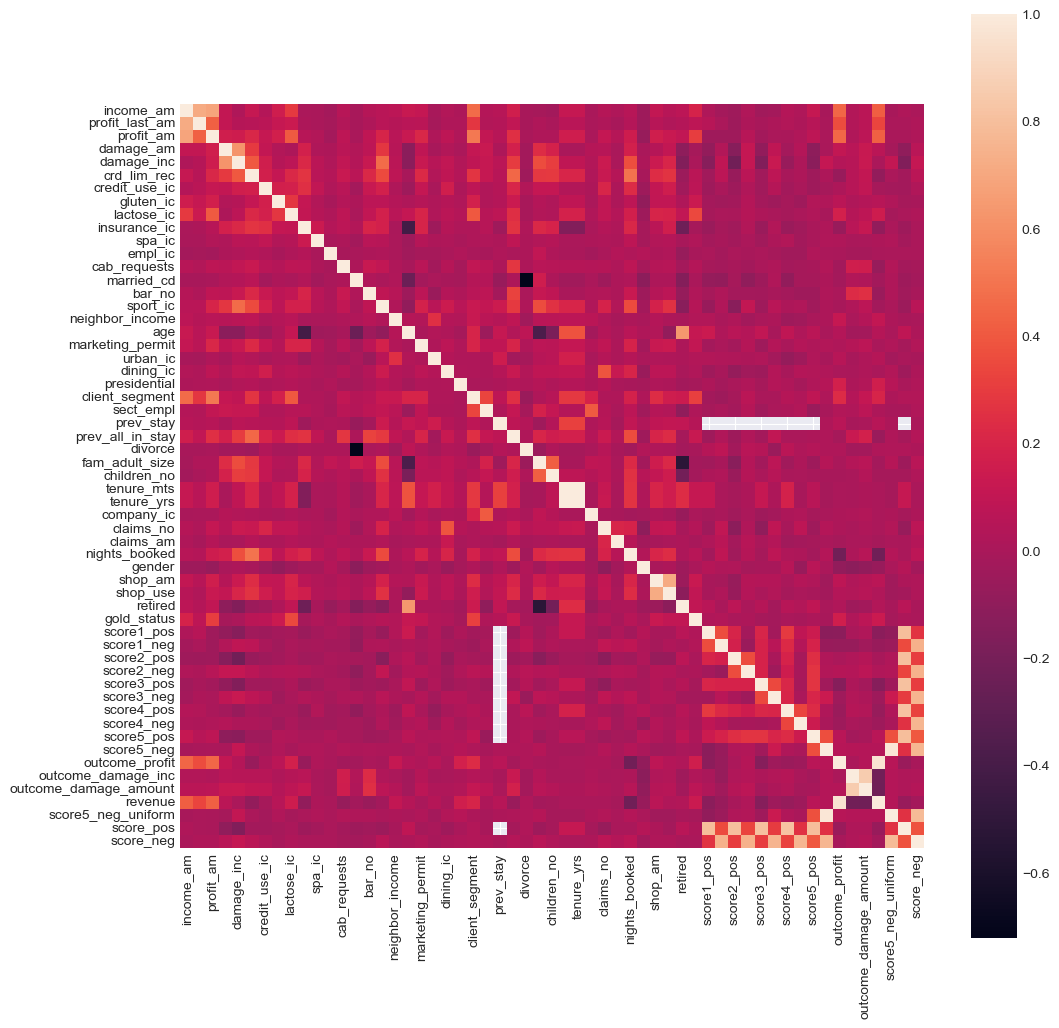

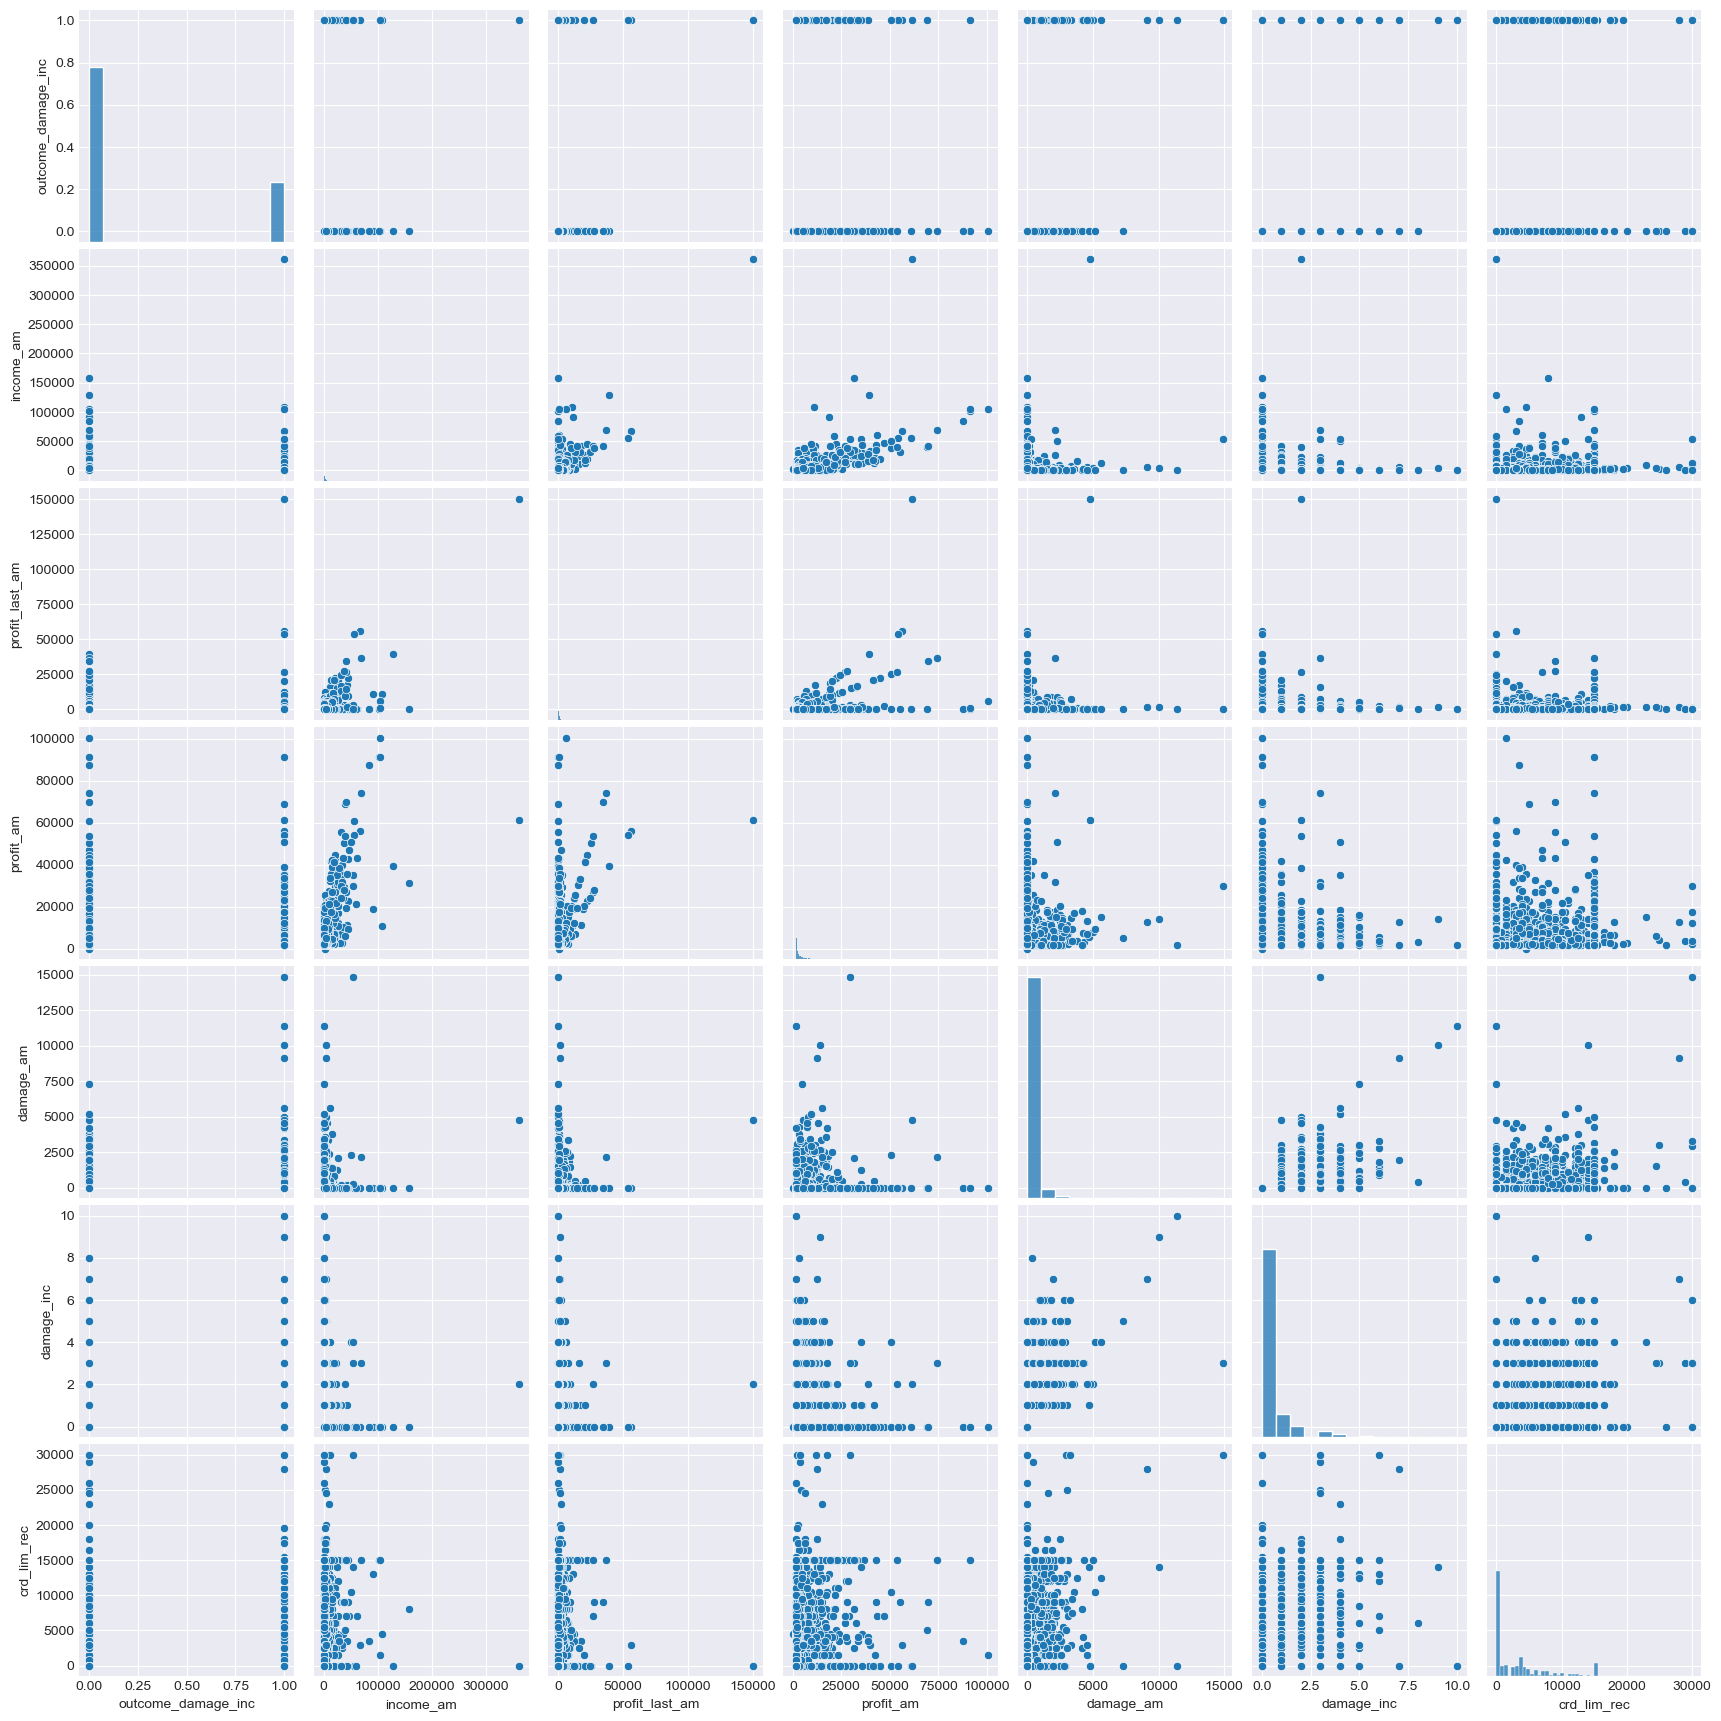

In [19]:
# Boxplot-type for year built vs SalePrice
plt.figure(figsize=(25, 10), dpi=500)  # Bumping up image size and DPI for better viewing
sns.boxplot(x='divorce', y='outcome_profit', data=train_V2);
plt.xticks(rotation=90);  # To rotate x-axis labels
plt.title('Relationship of divorce versus profit');
plt.show()  # remember: necessary to do this when trying to plot multiple plots from a single cell!

# But I guess a scatter plot would've done well also
plt.scatter(x=train_V2['income_am'], y=train_V2['outcome_profit'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('income_am');
plt.ylabel('outcome_profit');
plt.title('Alternative: scatter plot of income versus profit');
plt.show() 

# Correlation matrix between features
corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
plt.figure(figsize=(12, 12));
sns.heatmap(corrmat, vmax=1, square=True);
# Note, we keep SalePrice in here as well, proceed with caution (no data snooping!)

# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

# Standardizing / train_test_split

In [20]:
# Standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

#

#train_v2_stan_df.drop('outcome_profit', axis=1)
#train_v2_stan_df.drop('outcome_damage_inc', axis=1)
#train_v2_stan_df.drop('outcome_damage_amount', axis=1)


# Anomaly detection

knn-imputer voor missing scores: add_indicator:

In [ ]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection
# Importing the correct class as usual
from sklearn.ensemble import IsolationForest

# Checking which hyperparameters are available
# print(f"Hyperparamerters for IsolationForest class: {IsolationForest().get_params()}")

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
if_model.fit(X=train_v2_stan_df)

# Predicting on the same data
y_pred_train = if_model.predict(X=train_v2_stan_df)


In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_v2_stan_df.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit'], axis=1), # features DF
                                                    train_v2_stan_df['revenue'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

# I'll also make standardized (normalized) versions
scaler = StandardScaler().set_output(transform='pandas')
scaler.fit(X=X_train)
X_train_norm = scaler.transform(X=X_train)
X_test_norm = scaler.transform(X=X_test)

- trainen op log outcome profit?
- 

In [68]:
X_train_norm.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,profit-damage,mean_score_pos,mean_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1354,-0.232426,-0.210118,-0.187241,-0.247911,-0.398632,-0.176828,-0.21058,-0.166146,-0.324598,-0.804365,1.253059,-0.159606,-0.015908,0.466613,-0.127374,-0.635974,0.299982,0.266694,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,-2.774616,-0.593141,-0.33749,1.284429,0.717721,-0.972604,-0.999904,-0.138328,-0.303361,-0.086108,0.950563,-0.981681,-0.303597,-0.428047,-0.468448,-0.192738,0.020732,-0.583799,-0.498456,0.161247,NaN,NaN
2710,-0.142058,-0.210118,-0.173051,1.772543,0.710745,0.150598,-0.21058,-0.166146,-0.324598,1.243217,1.253059,-0.159606,-1.948473,0.466613,-0.894608,1.572392,-0.399892,-0.102722,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,1.284429,1.907734,-0.296211,-0.291212,-0.138328,-0.303361,-0.086108,-0.753767,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,0.681184,-0.583799,-0.498456,0.808229,-1.789738,0.954767
198,0.030811,-0.207166,-0.018565,-0.247911,-0.398632,-0.722538,-0.21058,-0.166146,-0.324598,-0.804365,-0.798047,-0.159606,-0.660097,0.466613,0.064435,-0.635974,0.391775,0.943956,-1.001735,0.353726,-0.232833,-0.072505,3.385288,0.997221,0.360410,-0.593141,-0.33749,-1.199757,-0.472293,0.734796,0.732454,-0.138328,-0.303361,-0.086108,-0.673877,1.018661,8.393582,2.336191,-0.468448,-0.192738,0.879659,-0.583799,-0.498456,1.002656,-0.010489,-0.704904
205,-0.168584,-0.152252,-0.179614,-0.247911,-0.398632,0.041456,-0.21058,-0.166146,-0.324598,1.243217,-0.798047,-0.159606,-0.660097,0.466613,-0.702799,-0.635974,-0.698259,-1.026261,-1.001735,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,0.042336,-0.472293,-1.484824,-1.472366,-0.138328,-0.303361,-0.086108,-0.460835,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,-0.552790,-0.583799,-0.498456,-0.400578,1.704337,-0.310829
3363,-0.232426,-0.210118,-0.139352,1.223524,2.929499,-0.722538,-0.21058,-0.166146,-0.324598,-0.804365,-0.798047,-0.159606,-0.660097,0.466613,-0.319182,1.572392,0.578163,-1.026261,0.998268,0.353726,-0.232833,-0.072505,-0.370277,-0.255911,0.360410,-0.593141,-0.33749,1.284429,1.907734,0.570623,0.574967,-0.138328,-0.303361,-0.086108,-0.700507,1.018661,-0.303597,-0.428047,-0.468448,-0.192738,0.878189,-0.583799,-0.498456,1.001216,-1.015785,0.484031
